In [11]:
import pandas as pd
import numpy as np
import json
import requests
import re
from bs4 import BeautifulSoup

In [13]:
#Need to use a delay between page scrapes in order to prevent getting blocked by Yelp
from time import sleep

## Search city and food type
Get a list of businesses and their info:
- Name
- Address
- Star Rating
- Price Range
- Number of Reviews
- URL for business Yelp review page
- URL for image used as business icon

In [20]:
#ENTER SEARCH TERMS BELOW:
cuisine_type = "Gastropubs"
location = "Albany, NY"

#Generate URL based on search terms
base_url = "https://www.yelp.com"
search_url = f"{base_url}/search?find_desc={cuisine_type}&find_loc={location}"

In [54]:
#Search Term: beer
#Filters: Breweries, Pubs, Beergardens, Gastropubs, Brewpubs, Beerbar
search_url = "https://www.yelp.com/search?find_desc=beer&find_loc=Albany%2C%20NY&cflt=restaurants"
search_url = "https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY"

In [261]:
#request = requests.get(search_url)
#soup = BeautifulSoup(request.content,'html.parser')

In [55]:
star_container_class = "lemon--div__373c0__1mboc attribute__373c0__1hPI_ display--inline-block__373c0__2de_K u-space-r1 border-color--default__373c0__2oFDT"
price_range_class = "lemon--span__373c0__3997G text__373c0__2pB8f priceRange__373c0__2DY87 text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_ text-bullet--after__373c0__1ZHaA"
review_count_class = "lemon--span__373c0__3997G text__373c0__2pB8f reviewCount__373c0__2r4xT text-color--mid__373c0__3G312 text-align--left__373c0__2pnx_"
next_page_class = "lemon--a__373c0__IEZFH link__373c0__29943 next-link navigation-button__373c0__1D3Ug link-color--blue-dark__373c0__1mhJo link-size--default__373c0__1skgq"
search_result_class = "lemon--div__373c0__1mboc searchResult__373c0__1yggB border-color--default__373c0__2oFDT"

In [56]:
next_page_url = search_url
page_counter = 1
#business_list = []

while next_page_url:
    request = requests.get(next_page_url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll(class_=search_result_class)
    print(f"Page {page_counter}, {len(search_results)-1} results {next_page_url}")
    result_counter = 1
    for search_result in search_results:
        business_info = {}
        try:
            business_name_url = search_result.findAll('a', href=True)[1]
            business_info['url'] = f"https://www.yelp.com{business_name_url['href']}"
            business_info['name'] = business_name_url['name']
            business_info['biz_id'] = business_name_url['href'].split('/biz/')[1].split('?')[0]
        except:
            continue
            
        try:
            business_info['address'] = search_result.find('address').text
        except:
            pass
        try:
            business_info['category'] = [category.text for category in search_result.findAll("a",attrs={"role":"link"})]
        except:
            pass
        try:
            business_info['star_rating'] = float(re.findall(r"[-+]?\d*\.\d+|\d+", 
                                                      search_result.find(
                                                          class_=star_container_class).find('div')['aria-label'] )[0] )
        except:
            pass
        try:
            business_info['price_range'] = search_result.find(class_=price_range_class).text
        except:
            pass
        try:
            business_info['num_reviews'] = int(re.findall(r"[-+]?\d*\.\d+|\d+",
                                                      search_result.find(
                                                          class_=review_count_class).text )[0] )
        except:
            pass
        try:
            business_info['image_shown'] = search_result.find('img')['src']
        except:
            pass
            
        if business_info:
            business_list.append(business_info)
            
        result_counter+=1
            
    if soup.find(class_=next_page_class):
        next_page_url = base_url + soup.find(class_=next_page_class)['href']
        page_counter+=1
    else:
        break
    
    #Random delay between 2 and 20 seconds to prevent getting blocked
    sleep(np.random.randint(2,20))

len(business_list)

Page 1, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY
Page 2, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=10
Page 3, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=20
Page 4, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=30
Page 5, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=40
Page 6, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=50
Page 7, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=60
Page 8, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=70
Page 9, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=80
Page 10, 10 results https://www.yelp.com/search?find_desc=burger&find_loc=Albany%2C%20NY&start=90
Page 11, 10 results https://www.yelp.c

1761

In [57]:
business_info_df = pd.DataFrame(business_list)
#Drop businesses with no reviews
business_info_df.dropna(subset=['num_reviews'], inplace=True)
#Drop duplicates
business_info_df.drop(business_info_df[business_info_df.biz_id.duplicated(keep='first')].index, inplace=True)
print(len(business_info_df))
business_info_df.tail()

1081


,address,biz_id,category,image_shown,name,num_reviews,price_range,star_rating,url
1756,NaN,johnnys-to-go-schenectady,[Italian],https://s3-media4.fl.yelpcdn.com/bphoto/dr6Msn...,Johnny’s To-Go,5.0,NaN,3.0,https://www.yelp.com/biz/johnnys-to-go-schenec...
1757,93 W Campbell Rd,burger-grill-and-middle-eastern-cuisine-schene...,[Imported Food],https://s3-media1.fl.yelpcdn.com/assets/srv0/y...,Burger Grill & Middle Eastern Cuisine,2.0,NaN,2.0,https://www.yelp.com/biz/burger-grill-and-midd...
1758,908 River St,kennedy-fried-chicken-and-pizza-troy,"[Chicken Wings, Pizza, Halal]",https://s3-media1.fl.yelpcdn.com/bphoto/rvwZlp...,Kennedy Fried Chicken & Pizza,26.0,$,2.0,https://www.yelp.com/biz/kennedy-fried-chicken...
1759,123 4th St,ginos-pizzeria-troy,[Pizza],https://s3-media1.fl.yelpcdn.com/bphoto/Ie8eEW...,Gino’s Pizzeria,8.0,$,2.0,https://www.yelp.com/biz/ginos-pizzeria-troy?o...
1760,441 State St,nicos-pizzeria-schenectady,"[Pizza, Italian]",https://s3-media3.fl.yelpcdn.com/bphoto/XDhLzF...,Nico’s Pizzeria,45.0,$,3.0,https://www.yelp.com/biz/nicos-pizzeria-schene...


In [76]:
business_info_df.head()

,address,biz_id,category,image_shown,name,num_reviews,price_range,star_rating,url
0,234 Western Ave,the-cuckoos-nest-albany,"[Southern, American (New)]",https://s3-media1.fl.yelpcdn.com/bphoto/6ZAVl7...,The Cuckoo’s Nest,235.0,$$,4.5,https://www.yelp.com/biz/the-cuckoos-nest-alba...
1,79 N Pearl St,the-hollow-bar-and-kitchen-albany,"[American (New), Music Venues, Venues & Event ...",https://s3-media4.fl.yelpcdn.com/bphoto/XjDwO1...,The Hollow Bar & Kitchen,304.0,$$,4.0,https://www.yelp.com/biz/the-hollow-bar-and-ki...
2,182A Washington Ave,iron-gate-cafe-albany,[Cafes],https://s3-media3.fl.yelpcdn.com/bphoto/A01kLn...,Iron Gate Cafe,474.0,$$,4.5,https://www.yelp.com/biz/iron-gate-cafe-albany...
3,281 New Scotland Ave,the-albany-ale-and-oyster-albany,"[American (Traditional), Beer Bar]",https://s3-media3.fl.yelpcdn.com/bphoto/H-GObC...,The Albany Ale & Oyster,240.0,$$,4.5,https://www.yelp.com/biz/the-albany-ale-and-oy...
4,109 Wolf Rd,kuma-ani-albany-4,[Ramen],https://s3-media2.fl.yelpcdn.com/bphoto/ZX6doy...,Kuma Ani,22.0,NaN,4.5,https://www.yelp.com/biz/kuma-ani-albany-4?osq...


In [ ]:
#CLEAN UP CATEGORY VALUES - remove parenthesis
business_info_categories = []
for category in business_info_df.category:
    cat_list = []
    for cat in category:
        cat = cat.replace('(',' ')
        cat = cat.replace(')',' ')
        cat = re.sub(' +',' ', cat).strip()
        cat_list.append(cat)
    business_info_categories.append(cat_list)
business_info_df.category = business_info_categories

In [59]:
import matplotlib.pyplot as plt

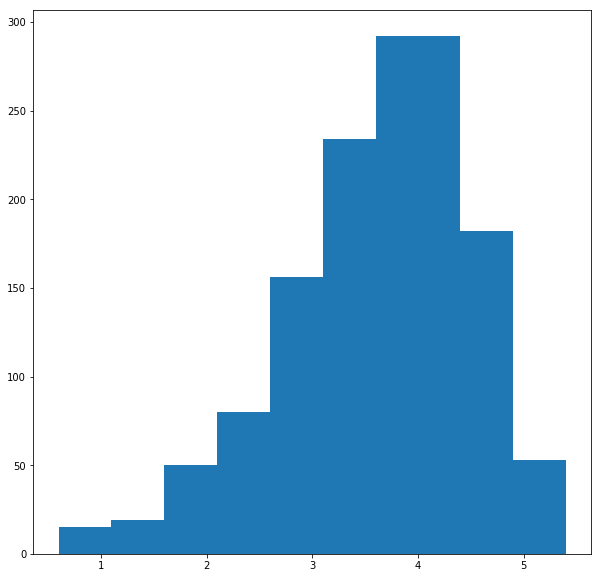

In [60]:
plt.figure(figsize=(10, 10))
plt.bar(business_info_df.star_rating.value_counts().index, business_info_df.star_rating.value_counts().values)
plt.show()

In [28]:
# generate document vectors or word vectors (embeddings)

# you'll need a word embeddings on all the data for modeling

# then make word embeddings for each star category

# tese embeddings should be used to compare 'word' similarities 

# pass a word like 'beer' or 'fish and chips' or 'fish' or 'burger' and look at 'most_similar' or pass in ['good', 'burger']



# make tfidf for each star rating and compare 'important' words across those ratings
# then compare stop words


# Question: How can we leverage yelp data to give us insights on our business? 

In [61]:
business_info_df.num_reviews.astype(int).sum()

59601

In [118]:
search_query_list = ['gastropub']*business_info_df.shape[0]

In [123]:
business_info_df['search_query'] = search_query_list

business_info_df.head()

,address,category,image_shown,name,num_reviews,price_range,star_rating,url,search_query
1,281 New Scotland Ave,"[American (Traditional), Beer Bar]",https://s3-media3.fl.yelpcdn.com/bphoto/H-GObC...,The Albany Ale & Oyster,240.0,$$,4.5,https://www.yelp.com/biz/the-albany-ale-and-oy...,gastropub
2,42 Howard St,"[Bars, American (Traditional), Gastropubs]",https://s3-media2.fl.yelpcdn.com/bphoto/rBAD9u...,The City Beer Hall,489.0,$$,4.0,https://www.yelp.com/biz/the-city-beer-hall-al...,gastropub
3,292 Delaware Ave,[Beer Bar],https://s3-media1.fl.yelpcdn.com/bphoto/vNnnpz...,Delaware Supply,24.0,$$,5.0,https://www.yelp.com/biz/delaware-supply-alban...,gastropub
4,1100 Madison Ave,"[American (New), Pubs]",https://s3-media3.fl.yelpcdn.com/bphoto/_q42sc...,Madison Pour House,125.0,$$,4.5,https://www.yelp.com/biz/madison-pour-house-al...,gastropub
5,1053 Broadway,"[Burgers, Brewpubs]",https://s3-media4.fl.yelpcdn.com/bphoto/wTLrpT...,Druthers Brewing Company,374.0,$$,4.0,https://www.yelp.com/biz/druthers-brewing-comp...,gastropub


## Get reviews for an individual business

In [264]:
def get_reviews(business_name, business_index, yelp_business_url, verbose=False):
    #THIS BLOCK OF CODE GATHERS ALL OF THE REVIEWS FOR A PARTICULAR BUSINESS
    
    #Class names used in Yelp Review pages.
    #There are two flavors of page design that yelp uses
    search_result_class_v1 = "lemon--li__373c0__1r9wz u-space-b3 u-padding-b3 border--bottom__373c0__uPbXS border-color--default__373c0__2oFDT"
    search_result_class_v2 = "review review--with-sidebar"
    
    #Set starting page (first page of reviews)
    next_page_url = yelp_business_url

    reviews_list = []
    page_counter=1

    #Continue to loop through review pages until there is no longer a "next" link at the bottom.
    while next_page_url:
        if verbose:
            #Print the page url being parsed
            print(f"Page {page_counter}, {next_page_url}")

        #Request html for page and load into BeautifulSoup object.
        request = requests.get(next_page_url)
        soup = BeautifulSoup(request.content,'html.parser')
        
        if len(soup.findAll(class_=search_result_class_v1))!=0:
            reviews_list.extend(get_reviews_page_v1(soup,business_name,business_index,verbose))
        elif len(soup.findAll(class_=search_result_class_v2))!=0:
            reviews_list.extend(get_reviews_page_v2(soup,business_name,business_index,verbose))
        else:
            print("Could not parse page: ", next_page_url)
        
        #Check for "next" page link - update next_page_url if found.
        #Break from while loop if there is no next page.
        if soup.find("link", attrs={'rel':'next'}):
            next_page_url = soup.find("link", attrs={'rel':'next'})['href']
            page_counter+=1
        else:
            break
        
        #Random delay between 1 and 4 seconds to prevent getting blocked
        sleep(np.random.randint(1,3))
    
    return reviews_list

In [63]:
def get_reviews_page_v1(soup, business_name, business_index, verbose=False):
    search_result_class = "lemon--li__373c0__1r9wz u-space-b3 u-padding-b3 border--bottom__373c0__uPbXS border-color--default__373c0__2oFDT"
    star_container_class = "lemon--div__373c0__1mboc arrange-unit__373c0__1piwO border-color--default__373c0__2oFDT"
    date_class = "lemon--span__373c0__3997G text__373c0__2pB8f text-color--mid__373c0__3G312 text-align--left__373c0__2pnx_"
    pic_class = "lemon--span__373c0__3997G photo-box-grid-item__373c0__2kFqV display--inline__373c0__1DbOG u-space-r2 u-space-b2 border-color--default__373c0__2oFDT"
    pic_url_class = "lemon--img__373c0__3GQUb photo-box-img__373c0__O0tbt"
    
    #Get each review block
    reviews = soup.findAll(class_=search_result_class)
    reviews_list=[]
    skipped_review_counter=0
    #Loop through each review and pull out pertinent information. Put into list of dictionaries.
    for review in reviews:
        try:
            review_info = {}
            review_info["business_name"] = business_name
            review_info["business_index"] = business_index
            review_info["date"] = review.find(class_=date_class).text.strip()
            #review_info["review"] = review.find("span", attrs={"class": "lemon--span__373c0__3997G", "lang": "en"}).text
            review_info["review"] = review.find(attrs={"lang": "en"}).text
            review_info['star_rating'] = float(re.findall(r"[-+]?\d*\.\d+|\d+", 
                           review.find(class_=star_container_class).find('div')['aria-label'] )[0] )
            review_info["pic_count"] = len(review.find_all(class_=pic_class))
            review_info["pic_urls"] = [obj['src'] for obj in review.findAll(class_=pic_url_class)]

            #Sometimes the user id is not being found
            try:
                review_info["user_id"] = review.find('a')['href'].split('userid=')[1]
            except:
                None

            reviews_list.append(review_info)
        except:
            skipped_review_counter+=1
            
    if verbose:
        if skipped_review_counter!=0:
            print(f"Skipped {skipped_review_counter} reviews")

    return(reviews_list)

In [64]:
def get_reviews_page_v2(soup, business_name, business_index, verbose=False):
    search_result_class = "review review--with-sidebar"
    star_container_class = "biz-rating__stars"
    date_class = "rating-qualifier"
    review_photo_box_class = "photo-box-grid clearfix js-content-expandable lightbox-media-parent"
    
    #Get each review block
    reviews = soup.findAll(class_=search_result_class)
    reviews_list=[]
    skipped_review_counter=0
    #Loop through each review and pull out pertinent information. Put into list of dictionaries.
    for review in reviews:
        try:
            review_info = {}
            review_info["business_name"] = business_name
            review_info["business_index"] = business_index
            review_info["date"] = review.find(class_=date_class).text.strip()
            review_info["review"] = review.find(attrs={"lang": "en"}).text
            review_info['star_rating'] = float(re.findall(r"[-+]?\d*\.\d+|\d+", 
                           review.find(class_=star_container_class).find('div')['title'])[0] )
            try:
                pic_line_items = review.find(class_=review_photo_box_class).findAll('li')
                review_info["pic_count"] = len(pic_line_items)
                review_info["pic_urls"] = [obj.find('img')['src'] for obj in pic_line_items]
            except:
                review_info["pic_count"] = 0
                review_info["pic_urls"] = []

            #Sometimes the user id is not being found
            try:
                review_info["user_id"] = review.find('a')['href'].split('userid=')[1]
            except:
                None

            reviews_list.append(review_info)
        except:
            skipped_review_counter+=1

    if verbose:
        if skipped_review_counter!=0:
            print(f"Skipped {skipped_review_counter} reviews")
            
    return(reviews_list)

In [77]:
index_num = 4
business_url = business_info_df.url[index_num]
business_name = business_info_df.name[index_num]
business_index = business_info_df.biz_id[index_num]
print(business_name)
print(business_url)

Kuma Ani
https://www.yelp.com/biz/kuma-ani-albany-4?osq=restaurants


In [78]:
reviews_df = pd.DataFrame(get_reviews(business_name,business_index, business_url,verbose=True))

Page 1, https://www.yelp.com/biz/kuma-ani-albany-4?osq=restaurants
Page 2, https://www.yelp.com/biz/kuma-ani-albany-4?osq=restaurants&start=20


In [79]:
reviews_df.head()

,business_index,business_name,date,pic_count,pic_urls,review,star_rating,user_id
0,kuma-ani-albany-4,Kuma Ani,9/1/2019,3,[https://s3-media2.fl.yelpcdn.com/bphoto/FLsrY...,I heard this place makes its own ramen noodles...,5.0,6HOtEJ8wp9Q3XkpLVStKnA
1,kuma-ani-albany-4,Kuma Ani,9/11/2019,3,[https://s3-media4.fl.yelpcdn.com/bphoto/IVQgv...,"Alright, a ramen place in Colonie! It's a welc...",4.0,JRSIPNLEpWnZkoFGGO-WDw
2,kuma-ani-albany-4,Kuma Ani,9/6/2019,3,[https://s3-media3.fl.yelpcdn.com/bphoto/Bf2jH...,As someone that loves japanese food when I hea...,4.0,MVIlQinGxgwPH_XOUpoXrA
3,kuma-ani-albany-4,Kuma Ani,8/26/2019,3,[https://s3-media2.fl.yelpcdn.com/bphoto/O8WK_...,I am very excited to have a ramen place in an ...,5.0,YX927Jezj85xgM_XX6bVxw
4,kuma-ani-albany-4,Kuma Ani,8/25/2019,0,[],"So, like I said... my 1st visit would not be m...",5.0,7MohwGwMyJaErZ_SRQQNdQ


In [73]:
reviews_df.star_rating.value_counts()

5.0    16
4.0     4
3.0     2
Name: star_rating, dtype: int64

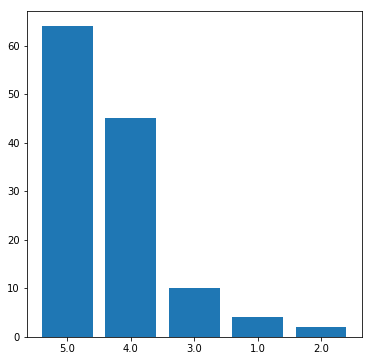

In [303]:
plt.figure(figsize=(6,6))
plt.bar(reviews_df.star_rating.value_counts().index.astype(str), reviews_df.star_rating.value_counts().values)
plt.show()

# Gathering ALL reviews for businesses in initial search
Get all reviews for businesses listed in the `business_info_df`

In [120]:
#last_index_completed = 0
#all_reviews = []

In [492]:
#Use call to set index starting point
#last_index_completed = 828
for i in range(5):
    print(last_index_completed + i,
          int(business_info_df.iloc[last_index_completed + i]['num_reviews']), "reviews\t",
          business_info_df.iloc[last_index_completed + i]['name'])

1076 5 reviews	 Johnny’s To-Go
1077 2 reviews	 Burger Grill & Middle Eastern Cuisine
1078 26 reviews	 Kennedy Fried Chicken & Pizza
1079 8 reviews	 Gino’s Pizzeria
1080 45 reviews	 Nico’s Pizzeria


In [493]:
#Divide into batches of 10 businesses at a time
batch_counter = 0
#while batch_counter < 100:
while last_index_completed < len(business_info_df):
    biz = business_info_df.iloc[last_index_completed]
    
    #Random delay between 1 and 5 seconds to try to prevent getting blocked
    sleep(np.random.randint(2,5))
    print(last_index_completed, int(biz['num_reviews']),"reviews\t", biz['name'], biz['url'], end='')
    all_reviews.extend(get_reviews(biz['name'],biz['biz_id'],biz['url'])) 
    print(" completed")
    last_index_completed+=1
    batch_counter+=1

1076 5 reviews	 Johnny’s To-Go https://www.yelp.com/biz/johnnys-to-go-schenectady?osq=burger completed
1077 2 reviews	 Burger Grill & Middle Eastern Cuisine https://www.yelp.com/biz/burger-grill-and-middle-eastern-cuisine-schenectady?osq=burger completed
1078 26 reviews	 Kennedy Fried Chicken & Pizza https://www.yelp.com/biz/kennedy-fried-chicken-and-pizza-troy?osq=burger completed
1079 8 reviews	 Gino’s Pizzeria https://www.yelp.com/biz/ginos-pizzeria-troy?osq=burger completed
1080 45 reviews	 Nico’s Pizzeria https://www.yelp.com/biz/nicos-pizzeria-schenectady?osq=burger completed


In [494]:
all_reviews_df = pd.DataFrame(all_reviews)
all_reviews_df.shape

(59280, 8)

In [524]:
all_reviews_df[all_reviews_df.review.duplicated(keep=False)]

,business_index,business_name,date,pic_count,pic_urls,review,star_rating,user_id
23948,ali-baba-troy,Ali Baba,12/22/2016,0,[],This is the best Mediterranean food you can pu...,5.0,NaN
28012,beirut-restaurant-troy,Beirut Restaurant,1/14/2017,0,[],This is the best Mediterranean food you can pu...,5.0,NaN
37345,cajun-cafe-albany,Cajun Cafe,3/29/2016,0,[],The only reason I gave 2 stars is because the ...,2.0,NaN
48115,cajun-cafe-and-grill-albany,Cajun Cafe & Grill,3/29/2016,0,[],The only reason I gave 2 stars is because the ...,2.0,NaN


In [526]:
len(all_reviews_df)

59274

Noticed that some dates have "updated" after them in the string indicating that the review was updated. I want to strip this information from the date field.

In [12]:
#Scrub date strings and convert to datetime type
scrubbed_dates = [re.sub("\D\D\D", "", date) for date in all_reviews_df.date]
all_reviews_df.date = pd.to_datetime(scrubbed_dates)

### Write dataframes to CSV files

In [11]:
#business_info_df.to_csv('business_info_all.csv',index=False)
all_reviews_df.to_csv('reviews_all.csv',index=False)